In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### Датасет

In [2]:
df = pd.read_csv("../data/train_features.csv", sep="|")
test = pd.read_csv("../data/test_features.csv", sep="|")
df.head()

,Button.left_dwell,Button.left_interval,Button.left_flight,Key.tab,Key.tab_dwell,Key.tab_interval,Key.tab_flight,Key.shift,Key.shift_dwell,Key.shift_interval,...,тор_dwell_second,тор_dwell_third,тор_interval_first,тор_interval_second,тор_flight_first,тор_flight_second,тор_up_to_up_first,тор_up_to_up_second,тор_latency,is_insider
0,82.18,472.27,469.34,0.572792,86.31,478.56,502.38,7.696897,307.92,178.98,...,115.0,110.75,372.5,563.25,233.25,178.25,237.5,174.0,522.25,0
1,75.87,479.03,460.12,0.000000,0.00,0.00,0.00,4.770889,312.07,203.07,...,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0
2,94.25,477.76,422.48,0.201005,70.50,414.50,485.00,7.939698,261.86,142.48,...,149.0,92.00,984.0,975.00,120.00,124.00,133.0,67.0,336.00,0
3,10.33,556.47,514.17,6.126238,175.98,477.89,496.30,4.863861,469.23,223.51,...,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0
4,27.35,464.80,492.16,2.222222,153.42,510.17,413.58,2.962963,375.38,122.50,...,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0


In [3]:
y = df['is_insider']
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state = 0, test_size = 0.2)
X_test = test
Y_test = test['is_insider']

In [4]:
medians = {} # словарь для хранения медиан для каждого столбца
# заполнение пустот в обучаемой выборке с помощью медиан
# и их использование для заполнения пустот в валидационной выборке
for col in x_train.columns:
    if col != 'is_insider':
        # медианы         
        medians[col + "_non_insider"] = x_train.loc[(x_train[col] != 0) & (x_train['is_insider'] == 0), col].median()
        medians[col + "_is_insider"] = x_train.loc[(x_train[col] != 0) & (x_train['is_insider'] == 1), col].median()
        # заполнение пустот в обучаемой выборке с помощью медиан из обучаемой выборки
        x_train.loc[(x_train[col] == 0) & (x_train['is_insider'] == 0), col] = medians[col + "_non_insider"] if medians[col + "_non_insider"] is not np.nan else 0 
        x_train.loc[(x_train[col] == 0) & (x_train['is_insider'] == 1), col] = medians[col + "_is_insider"] if medians[col + "_is_insider"] is not np.nan else 0
        # заполнение пустот в валидационной выборке с помощью медиан из обучаемой выборки
        x_test.loc[(x_test[col] == 0) & (x_test['is_insider'] == 0), col] = medians[col + "_non_insider"] if medians[col + "_non_insider"] is not np.nan else 0
        x_test.loc[(x_test[col] == 0) & (x_test['is_insider'] == 1), col] = medians[col + "_is_insider"] if medians[col + "_is_insider"] is not np.nan else 0
        # заполнение пустот в тестовой выборке с помощью медиан из обучаемой выборки
        X_test.loc[(X_test[col] == 0) & (X_test['is_insider'] == 0), col] = medians[col + "_non_insider"] if medians[col + "_non_insider"] is not np.nan else 0
        X_test.loc[(X_test[col] == 0) & (X_test['is_insider'] == 1), col] = medians[col + "_is_insider"] if medians[col + "_is_insider"] is not np.nan else 0
        
# очистка памяти
del medians

/Users/azamat/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
medians_insider = []
medians_non_insider = []
cols = []
special_keys = [
    "Key.esc",
    "Key.tab",
    "Key.caps_lock",
    "Key.shift",
    "Key.ctrl",
    "Key.alt",
    "Key.cmd",
    "Key.space",
    "Key.enter",
    "Key.backspace",
]
for col in x_train.columns:
    # не считаем медианы для таргета и частотных признаков
    if col != 'is_insider' and col not in special_keys:
        cols.append(col)
        medians_insider.append(x_train[x_train['is_insider'] == 1][col].median())
        medians_non_insider.append(x_train[x_train['is_insider'] == 0][col].median())   

In [6]:
rels = {
    "dwell": [0,0], # длительность нажатия первой буквы
    "interval": [0,0], # промежуток между отпусканием первой и нажатием второй буквы
    "flight": [0,0], # промежуток между нажатием первой и нажатием второй буквы
    "up_to_up": [0,0], # промежуток между отпусканием первой и отпусканием второй
    "dwell_first": [0,0], # длительность нажатия первой буквы
    "dwell_second": [0,0], # длительность нажатия второй буквы
    "dwell_third": [0,0], # длительность нажатия третьей буквы
    "interval_first": [0,0], # промежуток между отпусканием первой и нажатием второй буквы
    "interval_second": [0,0], # промежуток между отпусканием второй и нажатием третьей буквы
    "flight_first": [0,0], # промежуток между нажатием первой и нажатием второй буквы
    "flight_second": [0,0], # промежуток между нажатием второй и нажатием третьей буквы    
    "up_to_up_first": [0,0], # промежуток между отпусканием первой и отпусканием второй
    "up_to_up_second": [0,0], # промежуток между отпусканием второй и отпусканием третьей
    "latency": [0,0], # промежуток между нажатием первой и отпусканием третьей
}
for i in range(len(medians_insider)):
    for k,v in rels.items():
        if k in cols[i]:
            if medians_insider[i] < medians_non_insider[i]:
                v[0] += 1
            v[1] += 1

for k,v in rels.items():
    print(k,v[0],v[1],(v[1] - v[0]) / v[1] * 100 if v[1]-v[0] != 0 else 0)

dwell 43 58 25.862068965517242
interval 28 38 26.31578947368421
flight 30 38 21.052631578947366
up_to_up 22 30 26.666666666666668
dwell_first 16 20 20.0
dwell_second 16 20 20.0
dwell_third 7 10 30.0
interval_first 7 10 30.0
interval_second 6 10 40.0
flight_first 7 10 30.0
flight_second 7 10 30.0
up_to_up_first 7 10 30.0
up_to_up_second 6 10 40.0
latency 17 20 15.0


In [7]:
x_train.head()

,Button.left_dwell,Button.left_interval,Button.left_flight,Key.tab,Key.tab_dwell,Key.tab_interval,Key.tab_flight,Key.shift,Key.shift_dwell,Key.shift_interval,...,тор_dwell_second,тор_dwell_third,тор_interval_first,тор_interval_second,тор_flight_first,тор_flight_second,тор_up_to_up_first,тор_up_to_up_second,тор_latency,is_insider
31,117.65,483.99,434.97,5.395095,157.43,432.52,473.94,1.862069,340.11,404.22,...,96.0,76.00,492.0,93.0,98.0,158.00,100.0,158.0,380.0,1
29,126.89,402.90,446.46,5.395095,173.85,360.70,473.94,0.817439,635.20,262.20,...,96.0,76.00,492.0,93.0,98.0,158.00,100.0,158.0,380.0,1
20,138.74,466.59,481.88,3.385951,149.64,453.64,485.00,3.428571,196.33,25.54,...,106.5,97.14,532.0,102.5,143.0,176.25,153.0,174.0,412.0,0
39,136.96,433.00,454.58,5.395095,157.43,432.52,473.94,2.079208,527.29,453.14,...,96.0,76.00,492.0,93.0,98.0,158.00,100.0,158.0,380.0,1
2,94.25,477.76,422.48,0.201005,70.50,414.50,485.00,7.939698,261.86,142.48,...,149.0,92.00,984.0,975.0,120.0,124.00,133.0,67.0,336.0,0


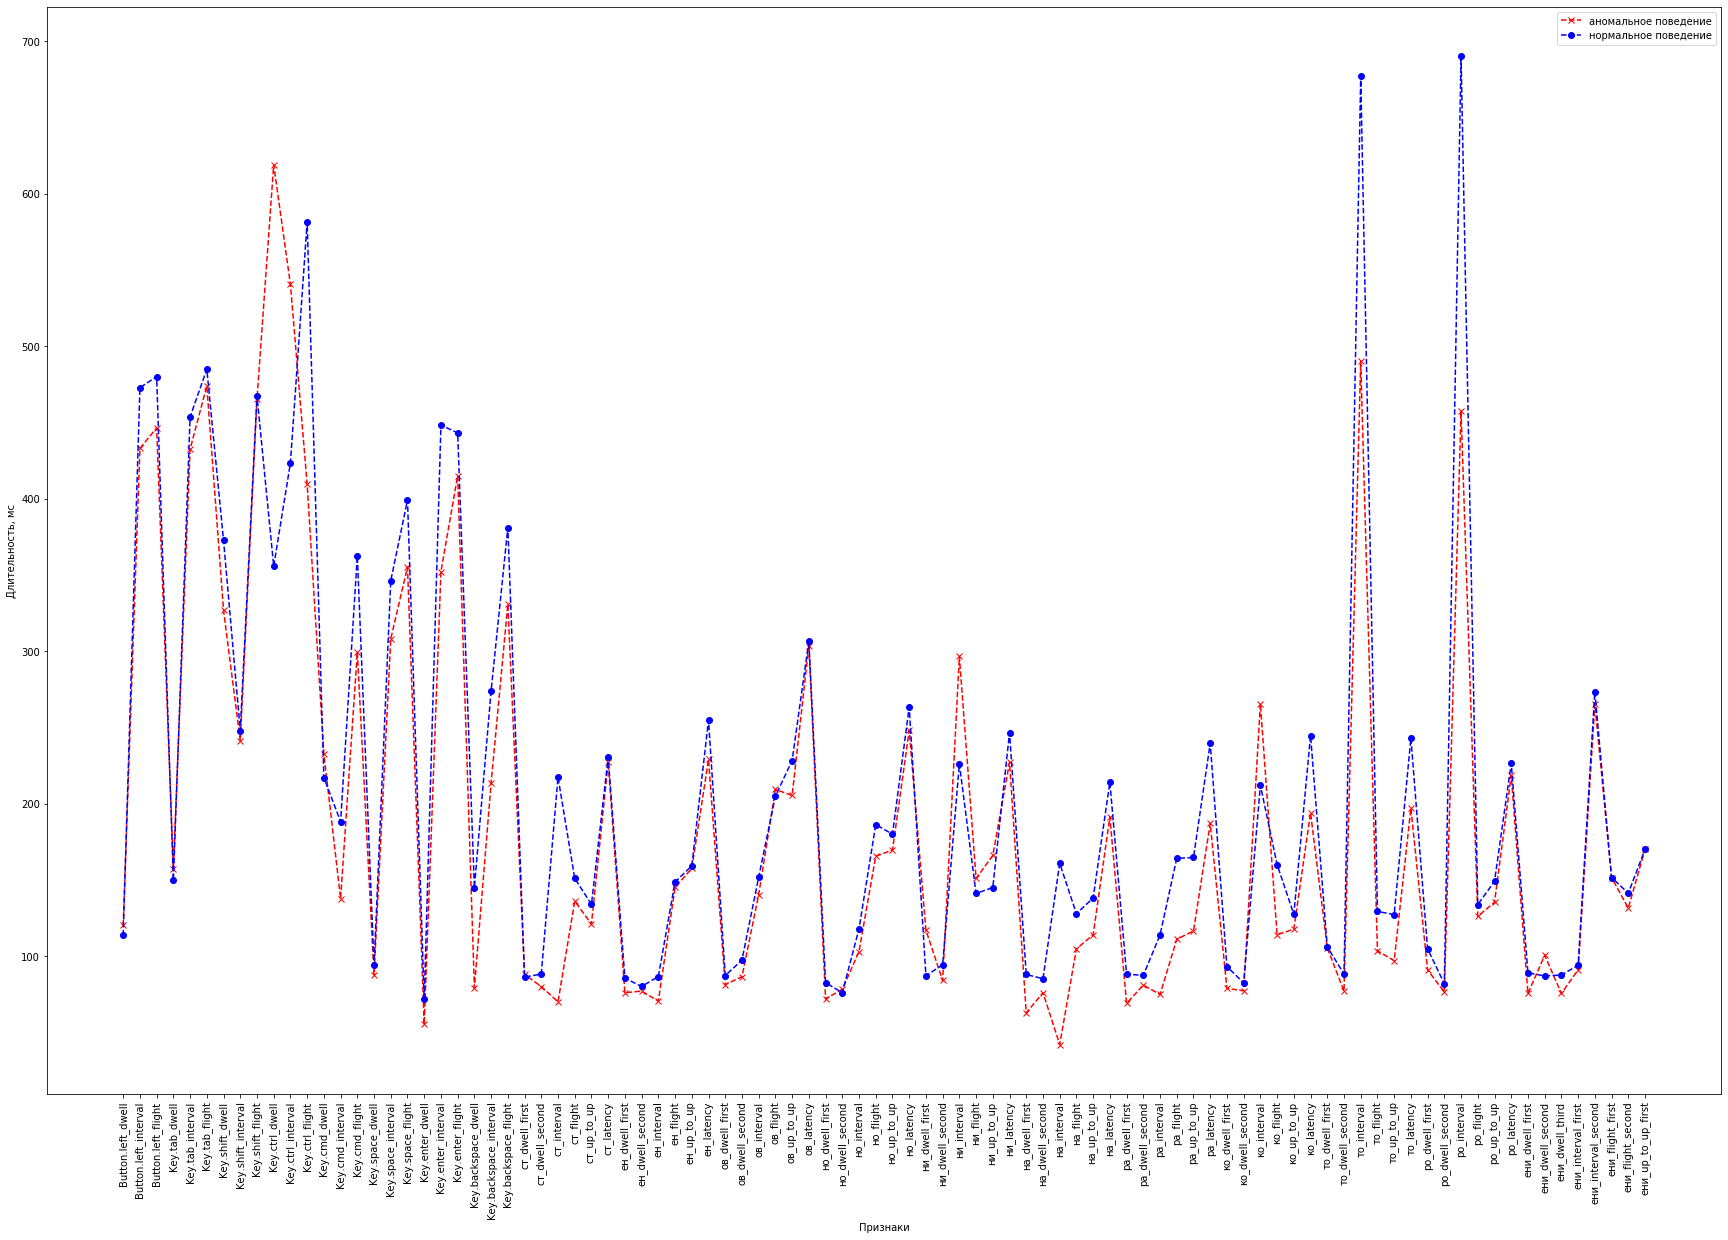

In [8]:
plt.figure(figsize=(30,20))
plt.plot(medians_insider[:92], '--rx', label = 'аномальное поведение')
plt.plot(medians_non_insider[:92], '--bo', label = 'нормальное поведение')
plt.legend()
plt.xticks(np.arange(len(cols)/2), labels=cols[:92], rotation=90)
plt.ylabel('Длительность, мс')
plt.xlabel('Признаки')
plt.savefig('first.png', bbox_inches='tight')
plt.show()

In [9]:
# удаление столбца is_insider из x_train и x_test
x_train.drop(columns = ['is_insider'], inplace = True)
x_test.drop(columns = ['is_insider'], inplace = True)
X_test.drop(columns = ['is_insider'], inplace = True)
x_train.head()

/Users/azamat/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Button.left_dwell,Button.left_interval,Button.left_flight,Key.tab,Key.tab_dwell,Key.tab_interval,Key.tab_flight,Key.shift,Key.shift_dwell,Key.shift_interval,...,тор_dwell_first,тор_dwell_second,тор_dwell_third,тор_interval_first,тор_interval_second,тор_flight_first,тор_flight_second,тор_up_to_up_first,тор_up_to_up_second,тор_latency
31,117.65,483.99,434.97,5.395095,157.43,432.52,473.94,1.862069,340.11,404.22,...,106.0,96.0,76.00,492.0,93.0,98.0,158.00,100.0,158.0,380.0
29,126.89,402.90,446.46,5.395095,173.85,360.70,473.94,0.817439,635.20,262.20,...,106.0,96.0,76.00,492.0,93.0,98.0,158.00,100.0,158.0,380.0
20,138.74,466.59,481.88,3.385951,149.64,453.64,485.00,3.428571,196.33,25.54,...,111.0,106.5,97.14,532.0,102.5,143.0,176.25,153.0,174.0,412.0
39,136.96,433.00,454.58,5.395095,157.43,432.52,473.94,2.079208,527.29,453.14,...,106.0,96.0,76.00,492.0,93.0,98.0,158.00,100.0,158.0,380.0
2,94.25,477.76,422.48,0.201005,70.50,414.50,485.00,7.939698,261.86,142.48,...,136.0,149.0,92.00,984.0,975.0,120.0,124.00,133.0,67.0,336.0


In [10]:
X_test.head(10)

,Button.left_dwell,Button.left_interval,Button.left_flight,Key.tab,Key.tab_dwell,Key.tab_interval,Key.tab_flight,Key.shift,Key.shift_dwell,Key.shift_interval,...,тор_dwell_first,тор_dwell_second,тор_dwell_third,тор_interval_first,тор_interval_second,тор_flight_first,тор_flight_second,тор_up_to_up_first,тор_up_to_up_second,тор_latency
0,48.41,477.83,476.66,0.525739,162.75,190.00,227.75,3.351588,397.90,272.04,...,65.0,31.00,89.0,142.00,315.00,207.00,346.00,173.00,404.00,642.0
1,146.20,443.25,453.64,0.878049,89.25,374.83,380.75,3.951220,402.06,202.63,...,103.0,89.67,99.0,970.67,67.67,73.67,157.33,60.33,166.67,330.0
2,252.58,458.51,480.32,0.504202,104.00,406.33,510.33,6.722689,183.07,121.33,...,78.0,70.00,74.0,85.50,87.00,163.50,157.00,155.50,161.00,394.5
3,170.12,460.24,492.43,0.251046,87.00,927.00,14.00,4.518828,396.72,362.56,...,106.0,96.00,76.0,492.00,93.00,98.00,158.00,100.00,158.00,380.0
4,140.07,587.78,445.24,5.395095,157.43,432.52,473.94,3.571429,359.80,432.60,...,106.0,96.00,76.0,492.00,93.00,98.00,158.00,100.00,158.00,380.0
5,267.34,481.75,463.38,5.395095,157.43,432.52,473.94,3.287671,255.83,297.83,...,106.0,96.00,76.0,492.00,93.00,98.00,158.00,100.00,158.00,380.0


### Метрики 

In [11]:
def report(clf, x_train, y_train, x_test, y_test, X_test, Y_test):
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    Y_pred = clf.predict(X_test)
    print("accuracy train:", clf.score(x_train,y_train), "accuracy validation", accuracy_score(y_test, y_pred), "accuracy_test", accuracy_score(Y_test, Y_pred))
    print(classification_report(y_test, y_pred))
    print(classification_report(Y_test, Y_pred))

### Модели

In [12]:
models = {
    'logistic regression': LogisticRegression(solver='lbfgs', random_state=0),
    'k-nearest neighbors': KNeighborsClassifier(n_neighbors=3),
    'naive bayes': BernoulliNB(),
    'support vector machines': SVC(kernel='linear', gamma='auto'),
    'random forest': RandomForestClassifier(max_depth=2, n_estimators = 200, random_state=0),
    'decision tree': DecisionTreeClassifier(),
    'adaptive boosting': AdaBoostClassifier(DecisionTreeClassifier(), algorithm="SAMME", n_estimators=200),
    'gradient boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=0),
    'multi-layer perceptron': MLPClassifier(alpha=0.1, max_iter=10000),
}

for k,v in models.items():
    print(k)
    report(v, x_train, y_train, x_test, y_test, X_test, Y_test)

logistic regression
accuracy train: 1.0 accuracy validation 1.0 accuracy_test 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

k-nearest neighbors
accuracy train: 1.0 accuracy validation 1.0 accuracy_test 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6

    accuracy      